In [2]:
import data_utils as du
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import compress
import scipy
from pathlib import Path

from matplotlib_venn import venn2

from utils.data import load_PPMI_data

data_dir = du.find_data_dir('app')
dataloader_file = du.get_file_path(data_dir, 'class based structure', 'dataloaders', 'dataloader.p')
dataloader = du.read_from_pickle(dataloader_file)

### Count number of nodes per type in PPMI networks

In [29]:
def node_types_counts(G):
    PPMI_type_mask = np.array([0 if 'HMDB' in node else 1 for node in G.nodes], dtype='int32')    
    n_nodes = len(G.nodes)
    n_metabolite_nodes = np.where(PPMI_type_mask==0, 1, 0).sum()
    n_protein_nodes = np.where(PPMI_type_mask==1, 1, 0).sum()
    return n_protein_nodes, n_metabolite_nodes, n_nodes

def compare_node_types_counts(dataloader):
    node_types_counts(dataloader.PPMI_full)
    node_types_counts(dataloader.PPMI_pruned)
    df = pd.DataFrame([node_types_counts(dataloader.PPMI_full), node_types_counts(dataloader.PPMI_pruned)], index=['Full PPMI', 'Pruned PPMI'], columns=['Proteins', 'Metabolites', 'Total']).T
    return df 

compare_node_types_counts(dataloader)

,Full PPMI,Pruned PPMI
Proteins,15835,11924
Metabolites,20759,228
Total,36594,12152


### Plot degree distributions

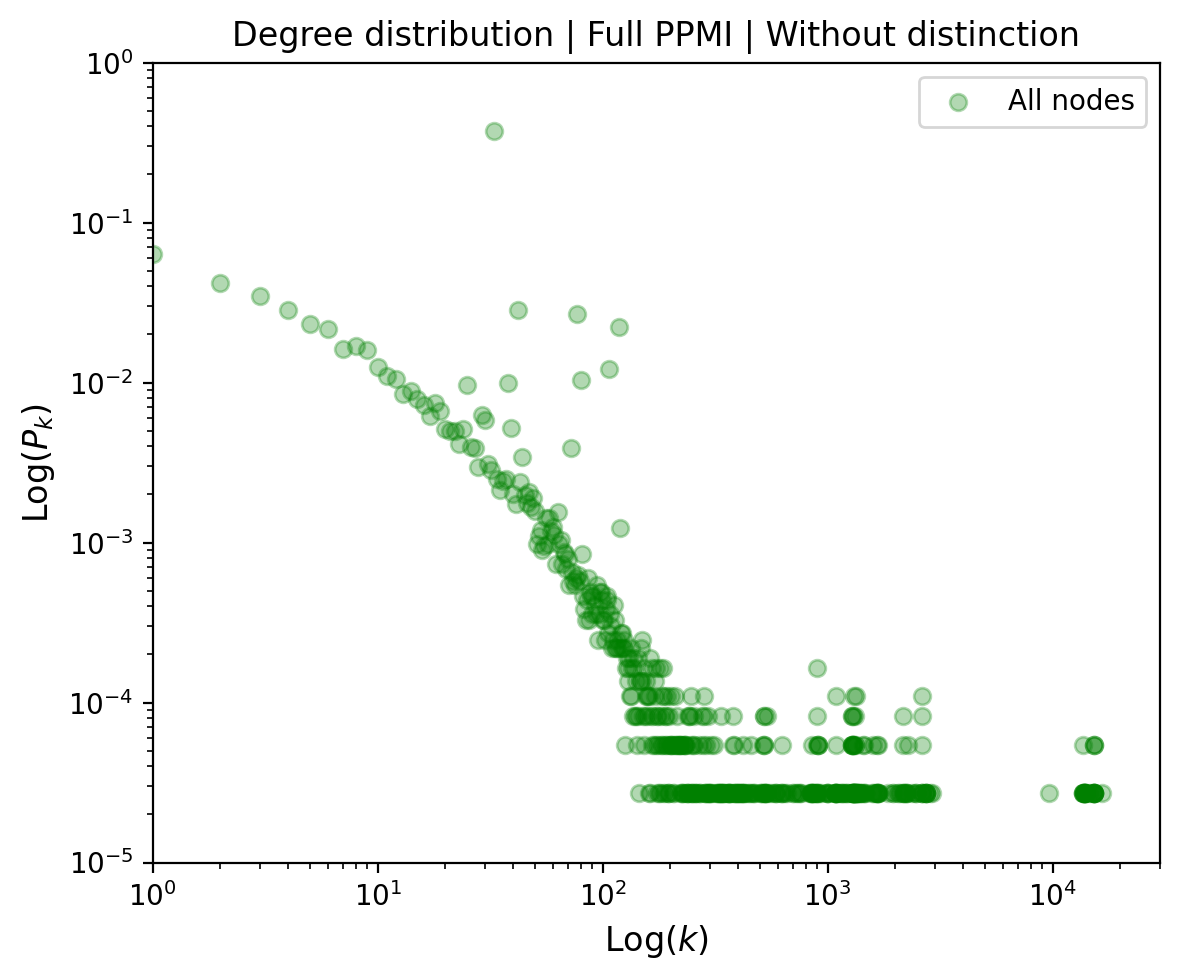

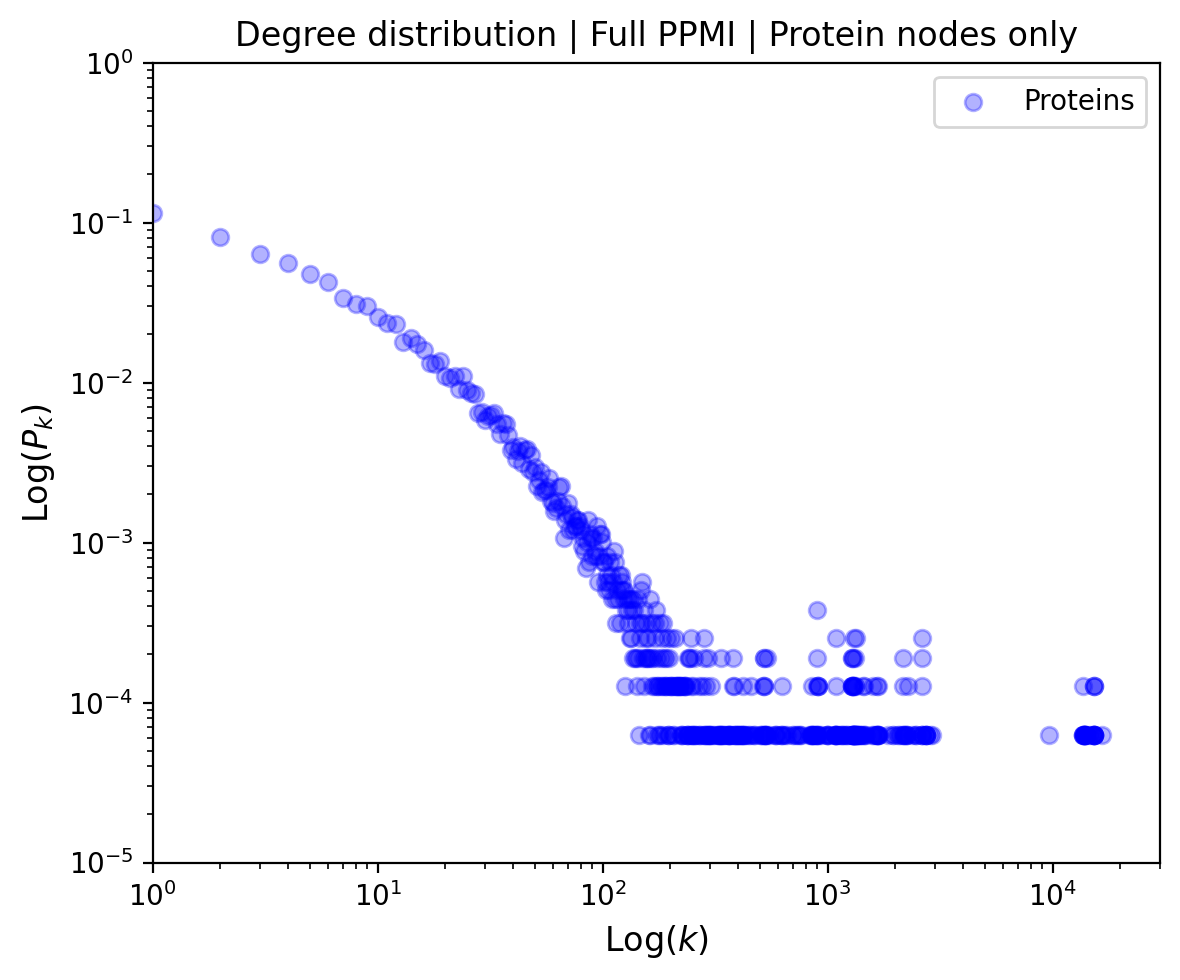

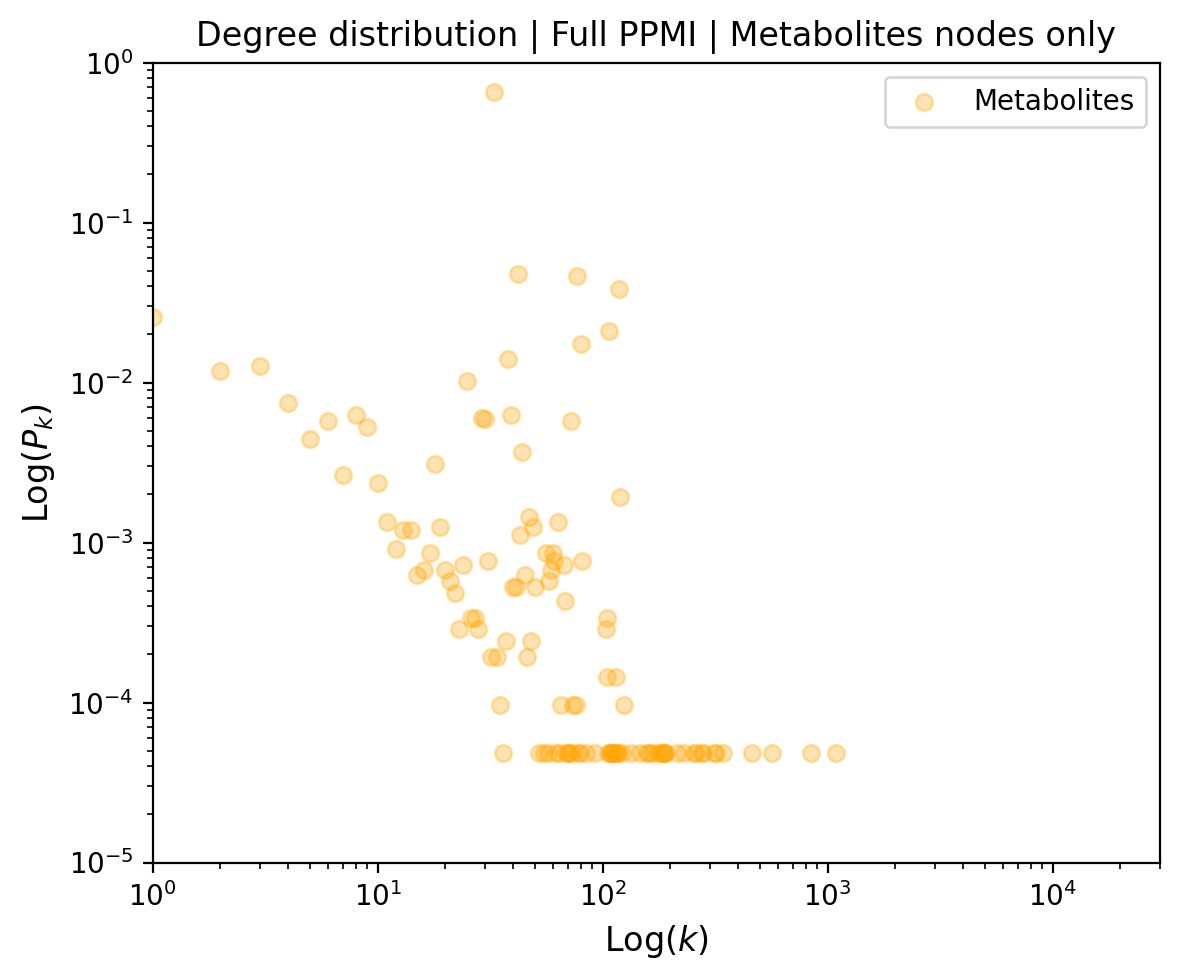

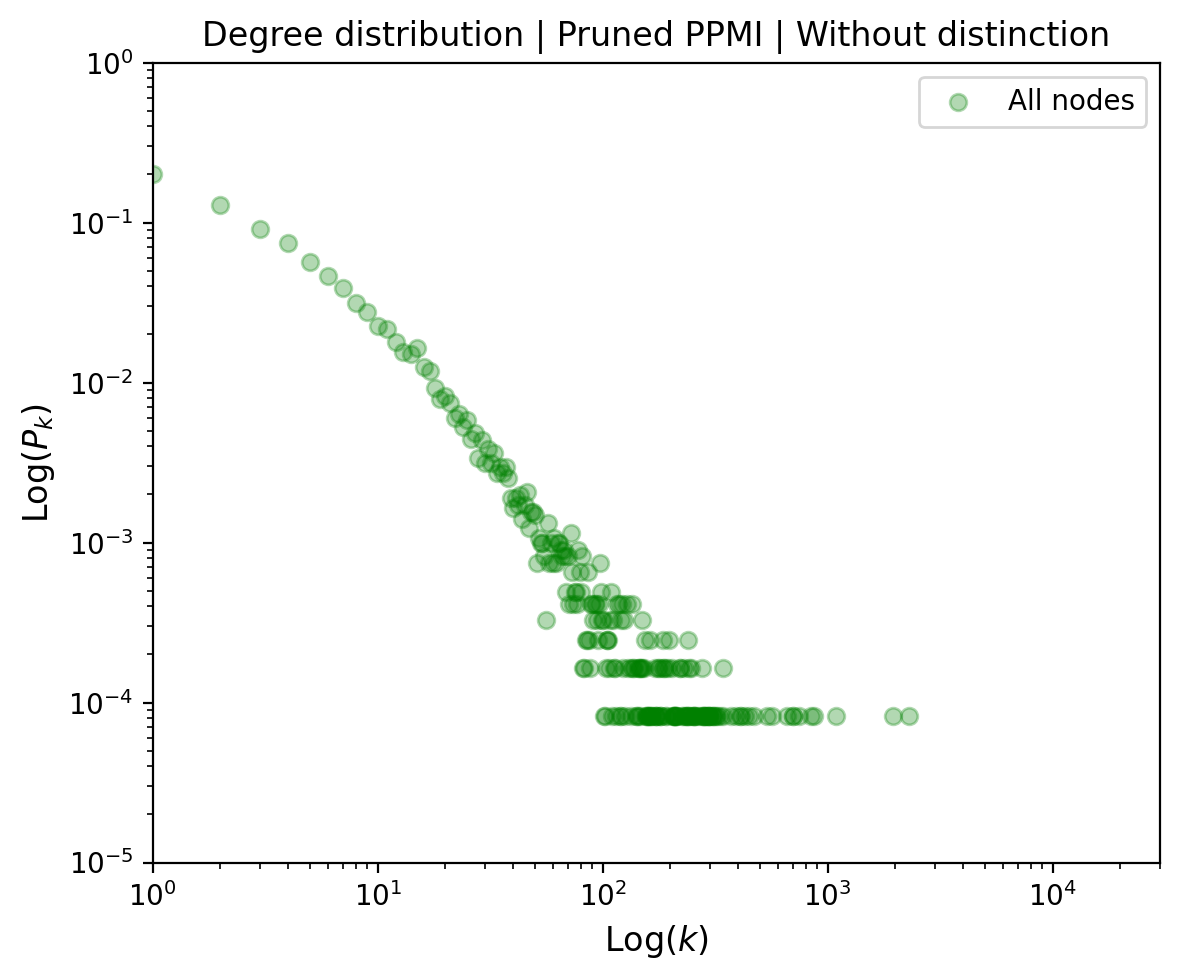

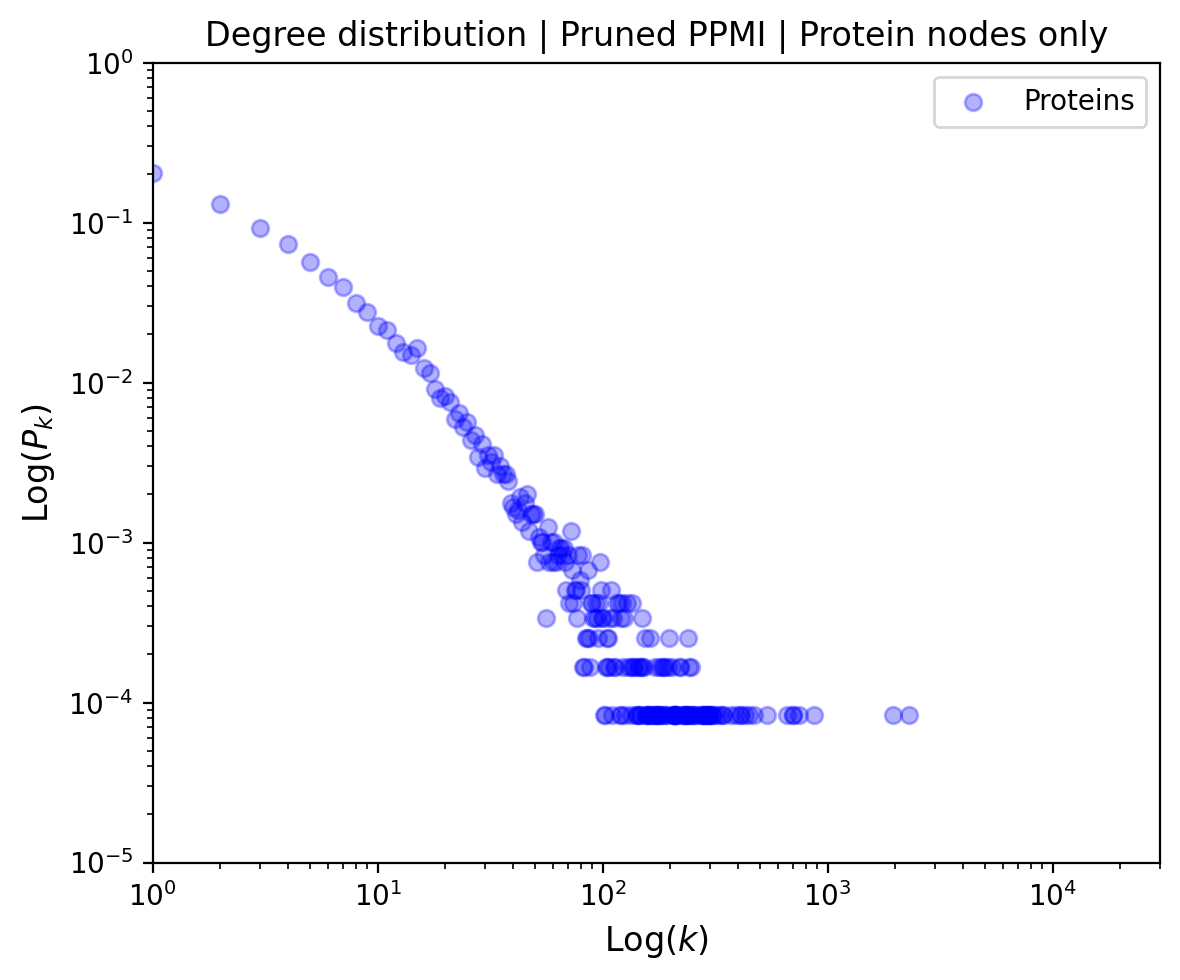

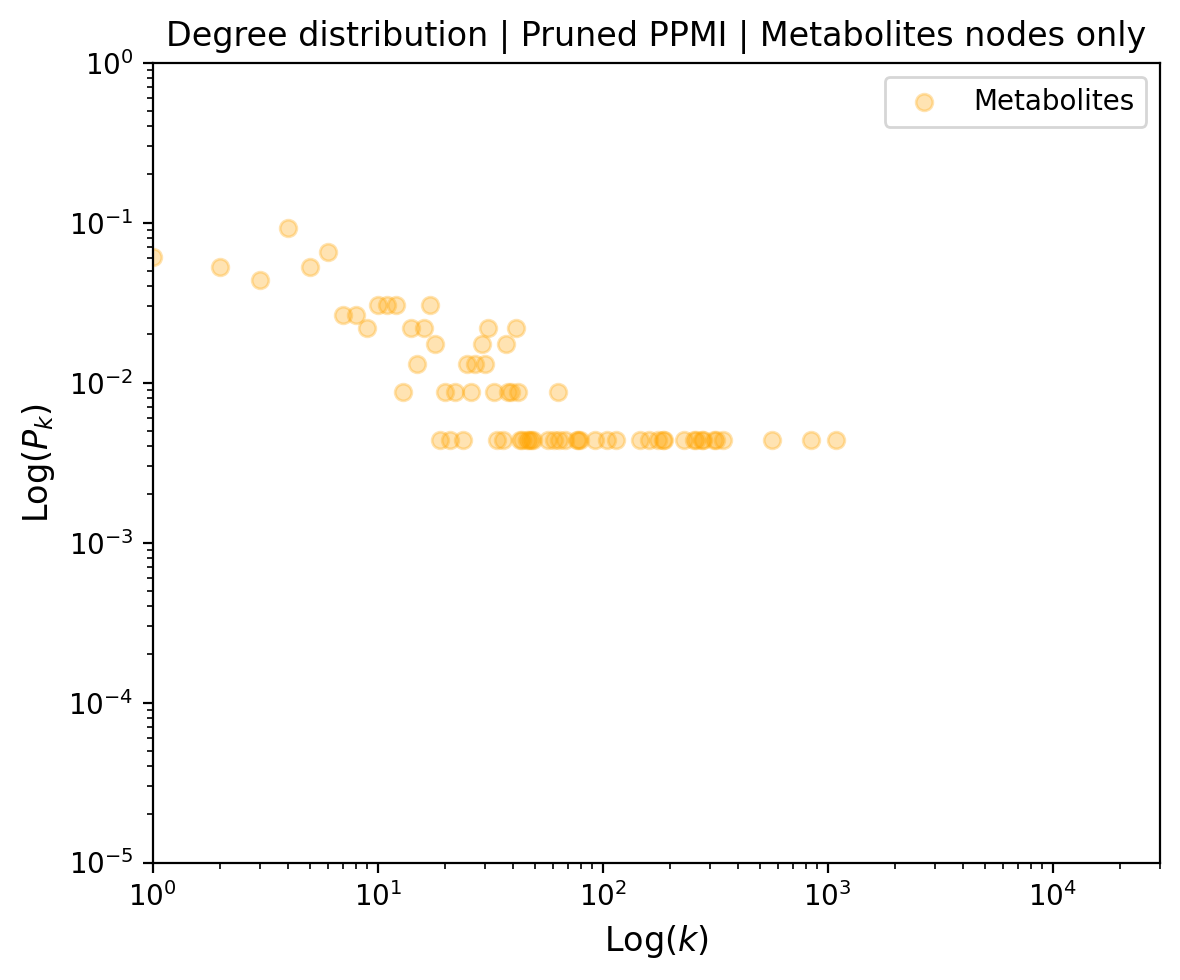

In [18]:
def plot_degree_distribution_per_nodetype(G, plot_metabolites=True, plot_proteins=True, title='', save_fig=False):
    PPMI_type_mask = np.array([0 if 'HMDB' in node else 1 for node in G.nodes], dtype='int32')
    
    n_nodes = len(G.nodes)
    n_metabolite_nodes = np.where(PPMI_type_mask==0, 1, 0).sum()
    n_protein_nodes = np.where(PPMI_type_mask==1, 1, 0).sum()

    nodes, degree_count = zip(*list(G.degree))
    degree_value_counts = pd.Series(degree_count, index=nodes).value_counts()
    P_k = degree_value_counts/n_nodes
    
    metabolite_nodes, metabolite_degree_count = zip(*list(compress(list(G.degree), list(PPMI_type_mask == [0]*n_nodes))))
    protein_nodes, protein_degree_count = zip(*list(compress(list(G.degree), list(PPMI_type_mask == [1]*n_nodes))))

    metabolite_degree_value_counts = pd.Series(metabolite_degree_count, index=metabolite_nodes).value_counts()
    metabolite_P_k = metabolite_degree_value_counts/n_metabolite_nodes

    protein_degree_value_counts = pd.Series(protein_degree_count, index=protein_nodes).value_counts()
    protein_P_k = protein_degree_value_counts/n_protein_nodes  

    alpha=.3
    fig = plt.figure(figsize=(6,5), dpi=200)
    fig.patch.set_facecolor('white')    

    plt.ylim([10**(-5), 10**(0)])    

    plt.yscale('log')
    plt.xscale('log')    

    plt.xlim([1, 30000])
    
    if plot_proteins and plot_metabolites:
        plt.scatter(P_k.index, P_k, color='green', alpha=alpha, label='All nodes')
    else:
        if plot_proteins:
            plt.scatter(protein_P_k.index, protein_P_k, color='blue', alpha=alpha, label='Proteins')
        if plot_metabolites:
            plt.scatter(metabolite_P_k.index, metabolite_P_k, color='orange', alpha=alpha, label='Metabolites')
    
    fontsize_labels=12
    pk_explanation_str = '   ($P_k$=probability)'
    k_explanation_str = '   ($k$=degree)'
    plt.xlabel('Log($k$)', fontsize=fontsize_labels)
    plt.ylabel('Log($P_k$)', fontsize=fontsize_labels)
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    if save_fig:
        filename = title.replace(' | ', '--') + '.png'
        plt.savefig(Path('figures', filename))
    plt.show()

general_title = 'Degree distribution'    
graph_name = 'Full PPMI'
plot_degree_distribution_per_nodetype(dataloader.PPMI_full, title=f'{general_title} | {graph_name} | Without distinction', save_fig=True)
plot_degree_distribution_per_nodetype(dataloader.PPMI_full, plot_metabolites=False, title=f'{general_title} | {graph_name} | Protein nodes only', save_fig=True)
plot_degree_distribution_per_nodetype(dataloader.PPMI_full, plot_proteins=False, title=f'{general_title} | {graph_name} | Metabolites nodes only', save_fig=True)

graph_name = 'Pruned PPMI'
plot_degree_distribution_per_nodetype(dataloader.PPMI_pruned, title=f'{general_title} | {graph_name} | Without distinction', save_fig=True)
plot_degree_distribution_per_nodetype(dataloader.PPMI_pruned, plot_metabolites=False, title=f'{general_title} | {graph_name} | Protein nodes only', save_fig=True)
plot_degree_distribution_per_nodetype(dataloader.PPMI_pruned, plot_proteins=False, title=f'{general_title} | {graph_name} | Metabolites nodes only', save_fig=True)

### Inspect metapath instances

In [32]:
adjlists, edge_metapath_indices_list, features_list, adjM, type_mask, labels, train_val_test_idx = load_PPMI_data()

In [33]:
def get_metapath_neighbor_count(metapath_id=0):
    n_nodes = len(edge_metapath_indices_list[metapath_id])
    metapath_neighbor_count = scipy.sparse.csr_matrix((n_nodes, n_nodes), dtype=float)
    for source, metapath_instances in edge_metapath_indices_list[metapath_id].items():
        metapath_neighbors, path_instance_counts = np.unique(metapath_instances[:,0], return_counts=True)
        source_target_count = list(zip([source]*len(metapath_neighbors), metapath_neighbors, path_instance_counts))

        for source, target, count in source_target_count:
            metapath_neighbor_count[source, target] = count
    return metapath_neighbor_count

MPM_neighbor_count = get_metapath_neighbor_count(0)
MPPM_neighbor_count = get_metapath_neighbor_count(1)

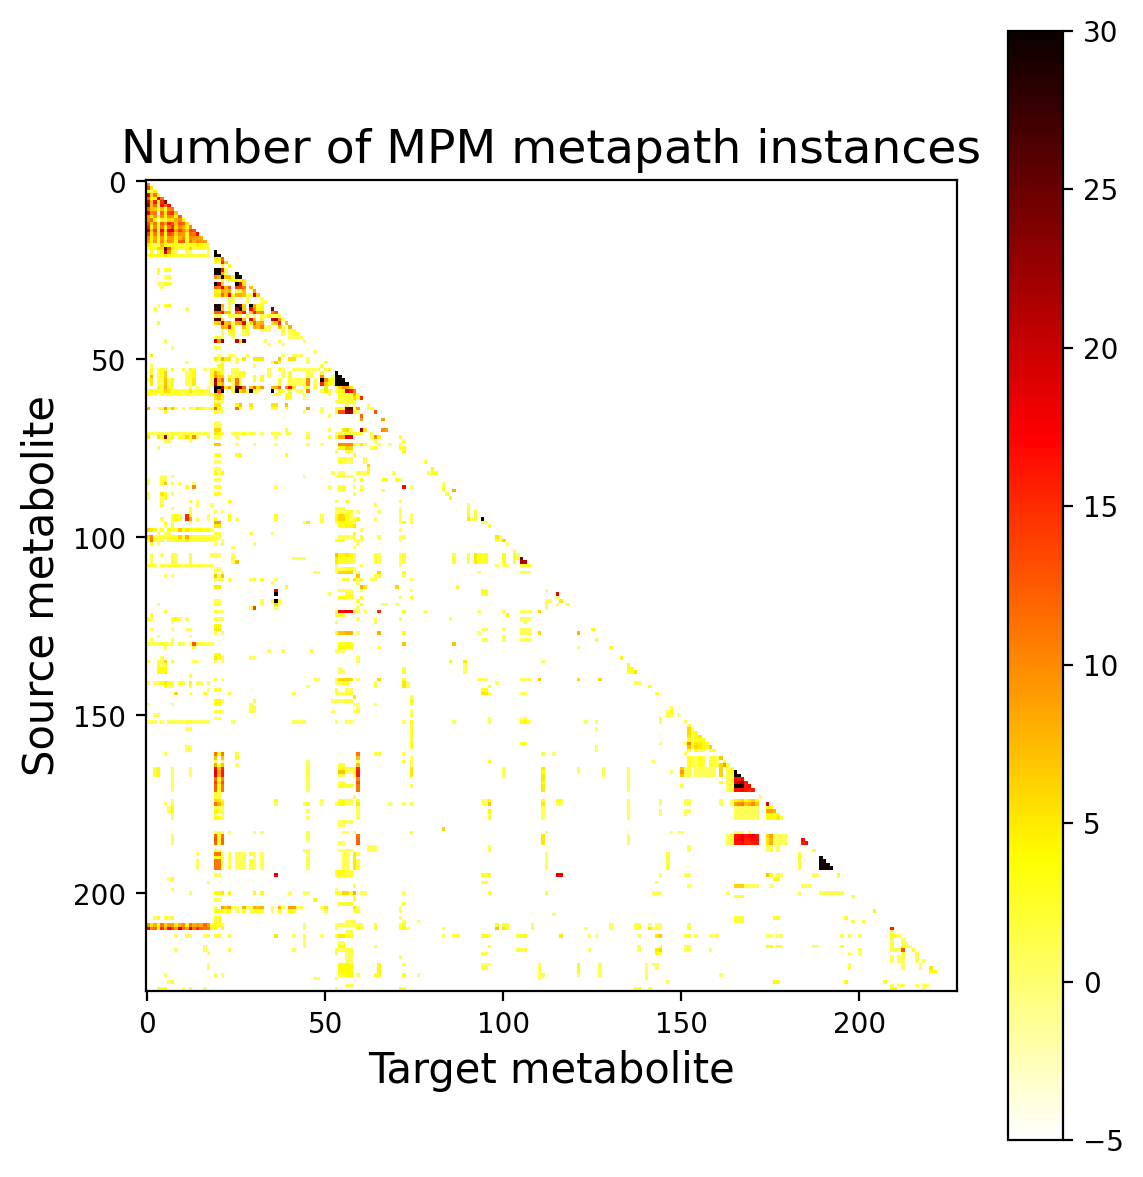

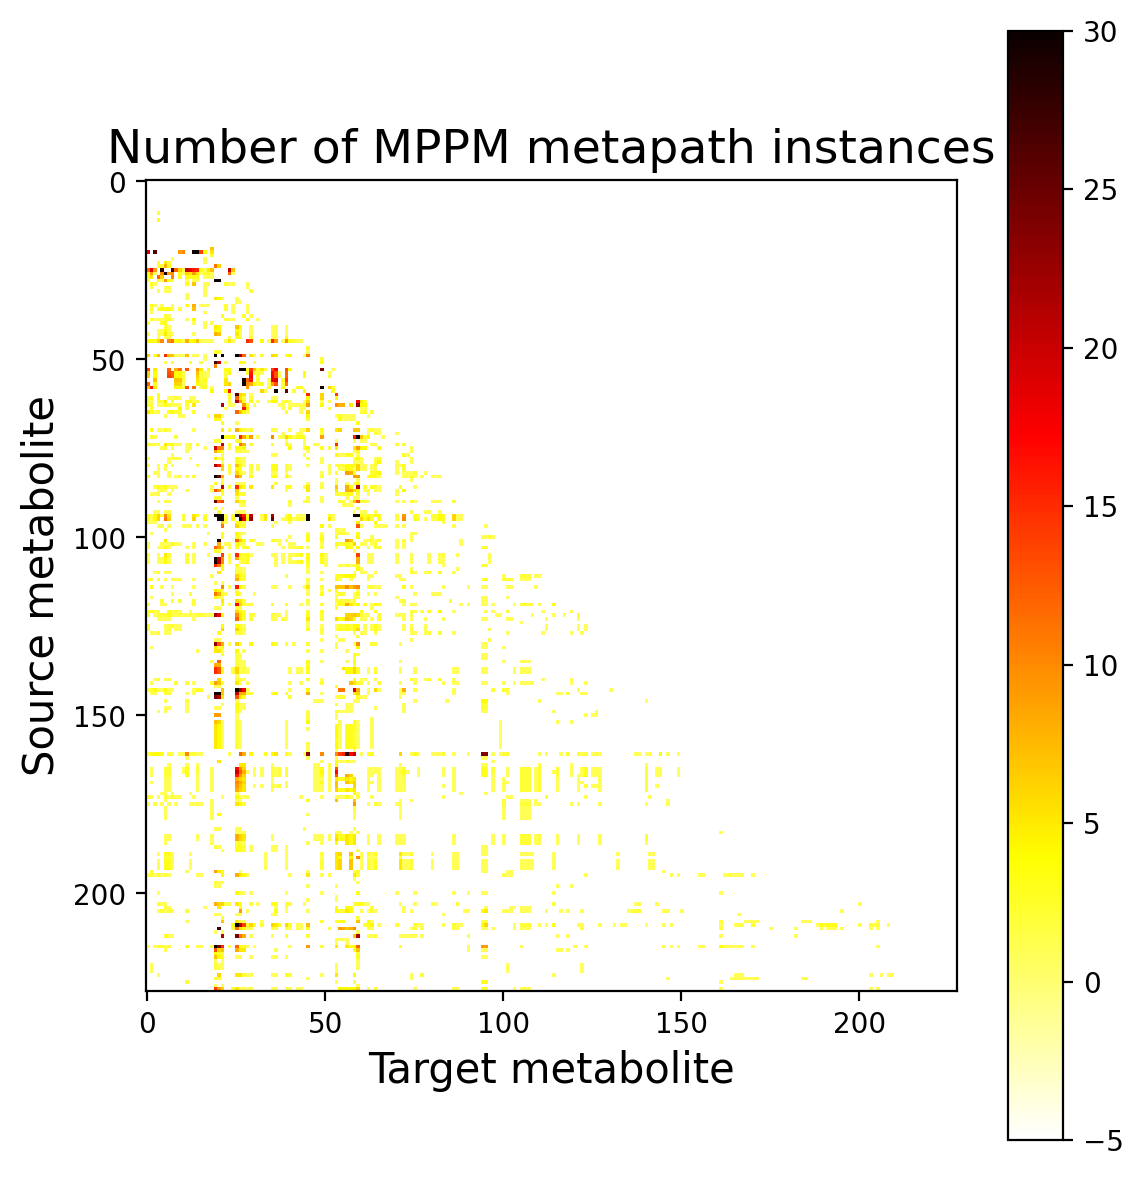

In [46]:
def plot_heatmap_metapath_neighbor_count(sparse_matrix, metapath, save_fig=False):
    max_neighborcount = 30
    zero_value = -5

    sparse_matrix = scipy.sparse.tril(sparse_matrix, format='csr')
    sparse_matrix[sparse_matrix > max_neighborcount] = max_neighborcount
    sparse_matrix[sparse_matrix == 0] = zero_value


    fig = plt.figure(figsize=(6,6), dpi=200)
    fig.patch.set_facecolor('white')    
    d=sparse_matrix.todense()
    plt.imshow(d,interpolation='none',cmap='hot_r')
    plt.ylabel('Source metabolite', fontsize=15)
    plt.xlabel('Target metabolite', fontsize=15)
    plt.colorbar()
    title=f'Number of {metapath} metapath instances'
    plt.title(title, fontsize=17)
    plt.tight_layout()
    if save_fig:
        filename = title + '.png'
        plt.savefig(Path('figures', filename))
    plt.show()

plot_heatmap_metapath_neighbor_count(MPM_neighbor_count, 'MPM', save_fig=True)
plot_heatmap_metapath_neighbor_count(MPPM_neighbor_count, 'MPPM', save_fig=True)

### Inspecting outliers with many metapath instances

In [67]:
def get_outliers(sparse_matrix, max_neighborcount, dataloader):
    outliers_matrix = scipy.sparse.tril(sparse_matrix, format='csr')
    outliers_matrix[sparse_matrix < max_neighborcount] = 0
    sources, targets, counts = scipy.sparse.find(outliers_matrix)

    HMDB_ids = dataloader.y.index

    df = pd.DataFrame(list(zip(HMDB_ids[sources], HMDB_ids[targets], counts)), columns=['Source', 'Target', 'MPM count'])
    df = df.sort_values('MPM count', ascending=False).reset_index(drop=True).astype({'MPM count': int})
    return df 

print(get_outliers(MPM_neighbor_count, 30, dataloader))

         Source       Target  MPM count
0   HMDB0001341  HMDB0000538        824
1   HMDB0000250  HMDB0000538        256
2   HMDB0001487  HMDB0000902        250
3   HMDB0000217  HMDB0000221        243
4   HMDB0000045  HMDB0000538        219
5   HMDB0000250  HMDB0000045        199
6   HMDB0001201  HMDB0001273        197
7   HMDB0001397  HMDB0001273        145
8   HMDB0001397  HMDB0001201        142
9   HMDB0000902  HMDB0000217        132
10  HMDB0001185  HMDB0000939        115
11  HMDB0001429  HMDB0000538        112
12  HMDB0001429  HMDB0001341        111
13  HMDB0001487  HMDB0000217        108
14  HMDB0000902  HMDB0000221        104
15  HMDB0001487  HMDB0000221         99
16  HMDB0001273  HMDB0000538         88
17  HMDB0000902  HMDB0001248         84
18  HMDB0000827  HMDB0000220         76
19  HMDB0000220  HMDB0000806         76
20  HMDB0000827  HMDB0000806         75
21  HMDB0001487  HMDB0001248         75
22  HMDB0000250  HMDB0001273         64
23  HMDB0000285  HMDB0000538         61


### Creating Venn diagrams of protein connections

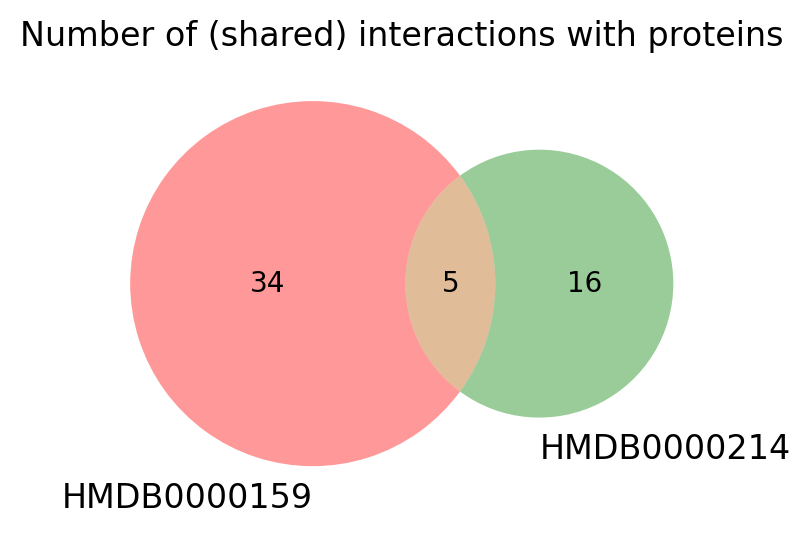

hmdb_accession
HMDB0000159    0
HMDB0000214    0
Name: CCS, dtype: object

In [66]:
def plot_venn_protein_links(metabolite_A, metabolite_B, save_fig=False):
    set_a = set(list(dataloader.PPMI_pruned[metabolite_A]))
    set_b = set(list(dataloader.PPMI_pruned[metabolite_B]))

    # Second way
    fig = plt.figure(figsize=(4,3.2), dpi=200)
    fig.patch.set_facecolor('white')    
    v = venn2([set_a, set_b], set_labels = (metabolite_A, metabolite_B))
    title = 'Number of (shared) interactions with proteins'
    plt.title(title)
    if save_fig:
        filename = title + '--' + metabolite_A + '-' + metabolite_B + '.png'
        plt.savefig(Path('figures', filename))
    plt.show()

def get_matapath_based_neighbors(dataloader, target_node_name, metapath_index=0):
    target_node_index = list(dataloader.y.index).index(target_node_name)
    metapaths_inspect = edge_metapath_indices_list[metapath_index][target_node_index]
    metapath_based_neighbors = pd.Series(metapaths_inspect[:, 0]).value_counts()
    metapath_based_neighbors.index = dataloader.y.index[np.array(metapath_based_neighbors.index)]
    name = f'{dataloader.y.index[target_node_index]}_metapath_{metapath_index}_based_neighbours'
    metapath_based_neighbors.name = name
    return metapath_based_neighbors


metabolite_1 = 'HMDB0000159'
metabolite_2 = 'HMDB0000214'
plot_venn_protein_links(metabolite_1, metabolite_2, save_fig=True)
dataloader.y[[metabolite_1, metabolite_2]]